<a href="https://colab.research.google.com/github/Harrisous/AIPI590_XAI_A5/blob/main/XAI_A5_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #04
## Haochen Li
Apply GradCAM and at least two of its variants to a meaningful image classification problem of your choice and analyze how and why the model makes its decisions.

Tasks
- Choose an image classification problem relevant to you (e.g., wildlife detection, object recognition in autonomous driving, or recycling classification).

- Use a pretrained computer vision model (e.g., ResNet-50, ViT) for your classification task. Transfer learning is optional.

- Apply Explainability Techniques:

  - Implement GradCAM and at least two GradCAM variants

  - Apply these techniques to at least 5 images from your dataset

- Generate and present visualizations showing what regions of the image the model is focusing on for its predictions.

- Compare and contrast the attention maps generated by GradCAM and its variants.

- Reflection:

  - Discuss the visual cues the model attends to

  - Comment on any surprising or misleading behavior

  - Reflect on why model explainability is important in your selected application domain

# My Choices (Background Setting)
- image classification task: automated vihecle pedestrian detection
- Dataset: BDD100K (from Kaggle)
https://www.kaggle.com/datasets/awsaf49/bdd100k-dataset
- Pre-trained CV model: ResNet50
- Running note: 1. manual operation needed in cell 1 and 2, cell2 needs your kaggle API key upload (json file), please prepare it in advance; 2. Full training set GPU RAM up to 72.7 GB, please choose appropriate GPU accordingly, OR change train_loader batch_size accordingly.
The current result shown ran on Google Colab A100 High RAM connection service.

In [1]:
# manual set the key parameters for training
size = '100k' # dataset size, 10k for test run, 100k for official run
transfer_epoch = 15 # transfer learning epoch, 3 for test run, 12 for official run
batch_size = 256*3 # batch size for training,
num_workers = 12 # number of workers(CPU) for dataloader

In [2]:
# 2. Upload personal Kaggle API token (kaggle.json) to Colab
import os
if not os.path.exists('bdd100k-dataset.zip'):
  from google.colab import files
  files.upload()  # Select kaggle.json from your local machine
  # 3. Move kaggle.json to the correct location
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json
else:
  print('kaggle.json already exists, skipping upload.')

kaggle.json already exists, skipping upload.


# 1. Data Preparation
Code are originally Generated by Perplexity, 9/30/2025 17:26; modification details (if any) will be illustrated in each block.

In [3]:
# Check if GPU is available
import torch
print('CUDA available:', torch.cuda.is_available())

CUDA available: True


In [4]:
# Generated by Perplexity, 9/30/2025 17:29
# 1. Install Kaggle API and required packages
!pip install -q kaggle torch torchvision matplotlib

In [5]:
# 4. Download BDD100K dataset from Kaggle
import os
# Check if the zip file already exists
if not os.path.exists('bdd100k-dataset.zip'):
    # If not, download and unzip
    !kaggle datasets download -d awsaf49/bdd100k-dataset
    !unzip -q bdd100k-dataset.zip -d bdd100k
else:
    print('bdd100k-dataset.zip already exists, skipping download and unzip.')

bdd100k-dataset.zip already exists, skipping download and unzip.


In [6]:
# 5. Check extracted folders
import os
print(os.listdir('bdd100k'))

['val.csv', 'labels', 'bdd100k', 'train.csv']


In [7]:
import os
img_dir = f'/content/bdd100k/bdd100k/bdd100k/images/{size}/train'
img_list = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
print('total number of training pictures', len(img_list))

total number of training pictures 70000


# 2. Transfer Learning
Code for this section are originally Generated by Perplexity, 9/30/2025 18:00; modification details (if any) will be illustrated in each block.

In [8]:
# modification: changed from 'person' to 'pedestrian'
# manual work: wrapped the labeling process to a function for val use
import os
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import json

# Define image and label directories
img_dir = f'/content/bdd100k/bdd100k/bdd100k/images/{size}/train'
label_path = '/content/bdd100k/labels/det_v2_train_release.json'

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def get_person_images_set(label_path):
  # Read the label json
  with open(label_path, 'r') as f:
      labels = json.load(f)

  # Build an index mapping image name to whether it contains a person
  person_images = set()
  for item in labels:
      img_name = item['name']
      labels_list = item.get('labels')
      if labels_list is not None:
        for label in labels_list:
            if label['category'] == 'pedestrian':  # BDD100K uses 'pedestrian' for person
                person_images.add(img_name)
                break
  return person_images

person_images = get_person_images_set(label_path)

In [9]:
# manual, to check number of training sample in train_release.json (name)
print('number of picture names in complete training set that have "pedestrian":', len(person_images))

number of picture names in complete training set that have "pedestrian": 22469


In [10]:
# List all images and assign labels
class BDDPedestrianDataset(Dataset):
    def __init__(self, img_dir, person_images, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_list = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
        self.person_images = person_images

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_name = self.img_list[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        # Label: 1 if the image has pedestrian, else 0
        label = 1 if img_name in self.person_images else 0
        if self.transform:
            image = self.transform(image)
        return image, label

train_dataset = BDDPedestrianDataset(img_dir, person_images, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [11]:
# manual, to check the number of the training sample in training folder (actual pictures)
print('number of training samples', len(train_dataset))

number of training samples 70000


In [12]:
# according to warning:
# /usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
#   warnings.warn(
# /usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
#   warnings.warn(msg)
# model = models.resnet50(pretrained=True) is modified


# transfer learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights # newly added to address warning issue

model = resnet50(weights=ResNet50_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Binary classification: pedestrian or not
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training loop (simple version)
for epoch in range(transfer_epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {correct/total:.2%}")


Epoch 1, Loss: 0.4118, Accuracy: 80.92%
Epoch 2, Loss: 0.3251, Accuracy: 85.86%
Epoch 3, Loss: 0.2414, Accuracy: 89.88%
Epoch 4, Loss: 0.1536, Accuracy: 93.84%
Epoch 5, Loss: 0.0893, Accuracy: 96.55%
Epoch 6, Loss: 0.0653, Accuracy: 97.62%
Epoch 7, Loss: 0.0547, Accuracy: 98.00%
Epoch 8, Loss: 0.0385, Accuracy: 98.61%
Epoch 9, Loss: 0.0290, Accuracy: 98.99%
Epoch 10, Loss: 0.0324, Accuracy: 98.82%
Epoch 11, Loss: 0.0294, Accuracy: 98.92%
Epoch 12, Loss: 0.0213, Accuracy: 99.26%
Epoch 13, Loss: 0.0415, Accuracy: 98.47%
Epoch 14, Loss: 0.0189, Accuracy: 99.35%
Epoch 15, Loss: 0.0137, Accuracy: 99.55%


# 2. Implement GradCAM and at least two GradCAM variants


## 2.1 GradCAM
Code for this section are originally Generated by Perplexity, 9/30/2025 19:44; modification details (if any) will be illustrated in each block.

In [13]:
!pip install -q grad-cam

In [14]:
# manual debug: removed torch.no_grad() before calling GradCAM since it will require gradient to generate the heatmap
# manual update: find 5 samples with pedestrian and 5 samples with with pedestrian from valset to visualize
# manual update: val set speration
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import os

val_img_dir = f'/content/bdd100k/bdd100k/bdd100k/images/{size}/train'
val_label_path = '/content/bdd100k/labels/det_v2_val_release.json'
val_person_images_name = get_person_images_set(val_label_path)

all_img_files = [f for f in os.listdir(val_img_dir) if f.endswith('.jpg')]
img_files_1 = [f for f in os.listdir(val_img_dir) if f.endswith('.jpg') and f in val_person_images_name]
img_files_0 = [f for f in os.listdir(val_img_dir) if f.endswith('.jpg') and f not in val_person_images_name]
print('All Val img number:', len(all_img_files))
print('Val img number with pedestrian:', len(img_files_1))
print('Val img number without pedestrian:', len(img_files_0))

All Val img number: 70000
Val img number with pedestrian: 0
Val img number without pedestrian: 70000


In [15]:
# manual adjustment: since val set has no img with pedestrian, train set here is used instead
val_img_dir = f'/content/bdd100k/bdd100k/bdd100k/images/{size}/train'
val_label_path = '/content/bdd100k/labels/det_v2_train_release.json'
val_person_images_name = get_person_images_set(val_label_path)

all_img_files = [f for f in os.listdir(val_img_dir) if f.endswith('.jpg')]
img_files_1 = [f for f in os.listdir(val_img_dir) if f.endswith('.jpg') and f in val_person_images_name]
img_files_0 = [f for f in os.listdir(val_img_dir) if f.endswith('.jpg') and f not in val_person_images_name]
print('All train img number:', len(all_img_files))
print('Train img number with pedestrian:', len(img_files_1))
print('Train img number without pedestrian:', len(img_files_0))

selected_imgs_person = img_files_1[:5]
selected_imgs_no_person = img_files_0[:5]
selected_imgs = selected_imgs_person + selected_imgs_no_person

All train img number: 70000
Train img number with pedestrian: 22469
Train img number without pedestrian: 47531


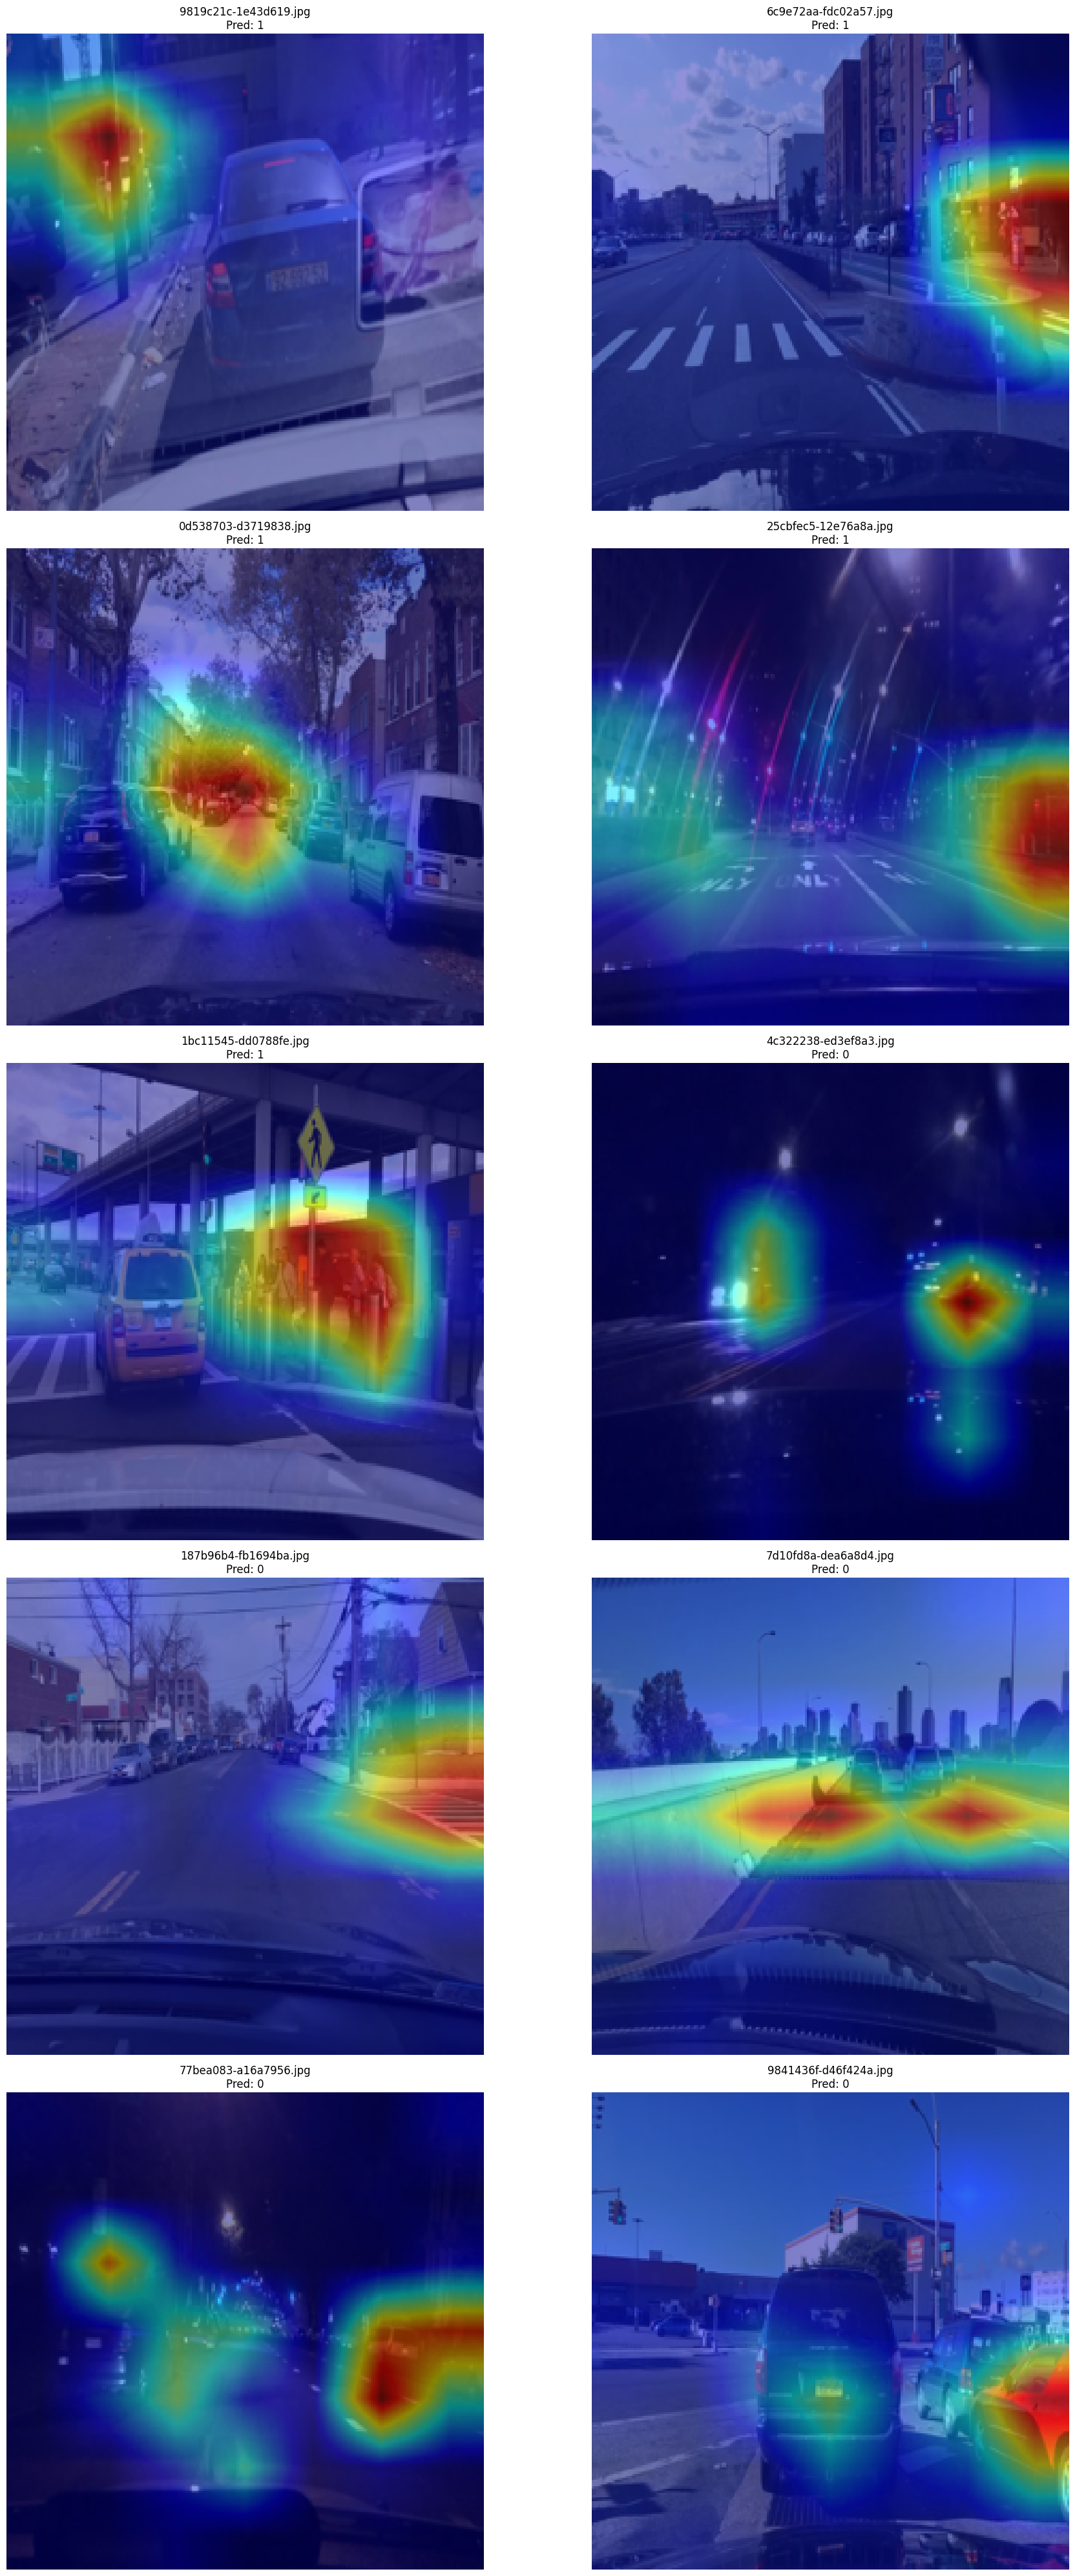

In [16]:
# 5. Prepare GradCAM
model.eval()
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

# 6. Visualization loop
fig, axes = plt.subplots(5, 2, figsize=(20, 40))
axes = axes.flatten()
for idx, img_name in enumerate(selected_imgs):
    img_path = os.path.join(val_img_dir, img_name)
    image = Image.open(img_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).cuda()
    img_np = np.array(image.resize((224, 224))).astype(np.float32) / 255.0
    outputs = model(input_tensor)
    pred_class = outputs.argmax(dim=1).item()
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred_class)])
    grayscale_cam = grayscale_cam[0]
    visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
    axes[idx].imshow(visualization)
    axes[idx].axis('off')
    axes[idx].set_title(f"{img_name}\nPred: {pred_class}")
plt.tight_layout()
plt.show()

## 2.2 Score-CAM
Scor-CAM is based on forward propagation.  
Genereated using Perplexity 16:56 10/1/2025

100%|██████████| 128/128 [00:01<00:00, 119.37it/s]


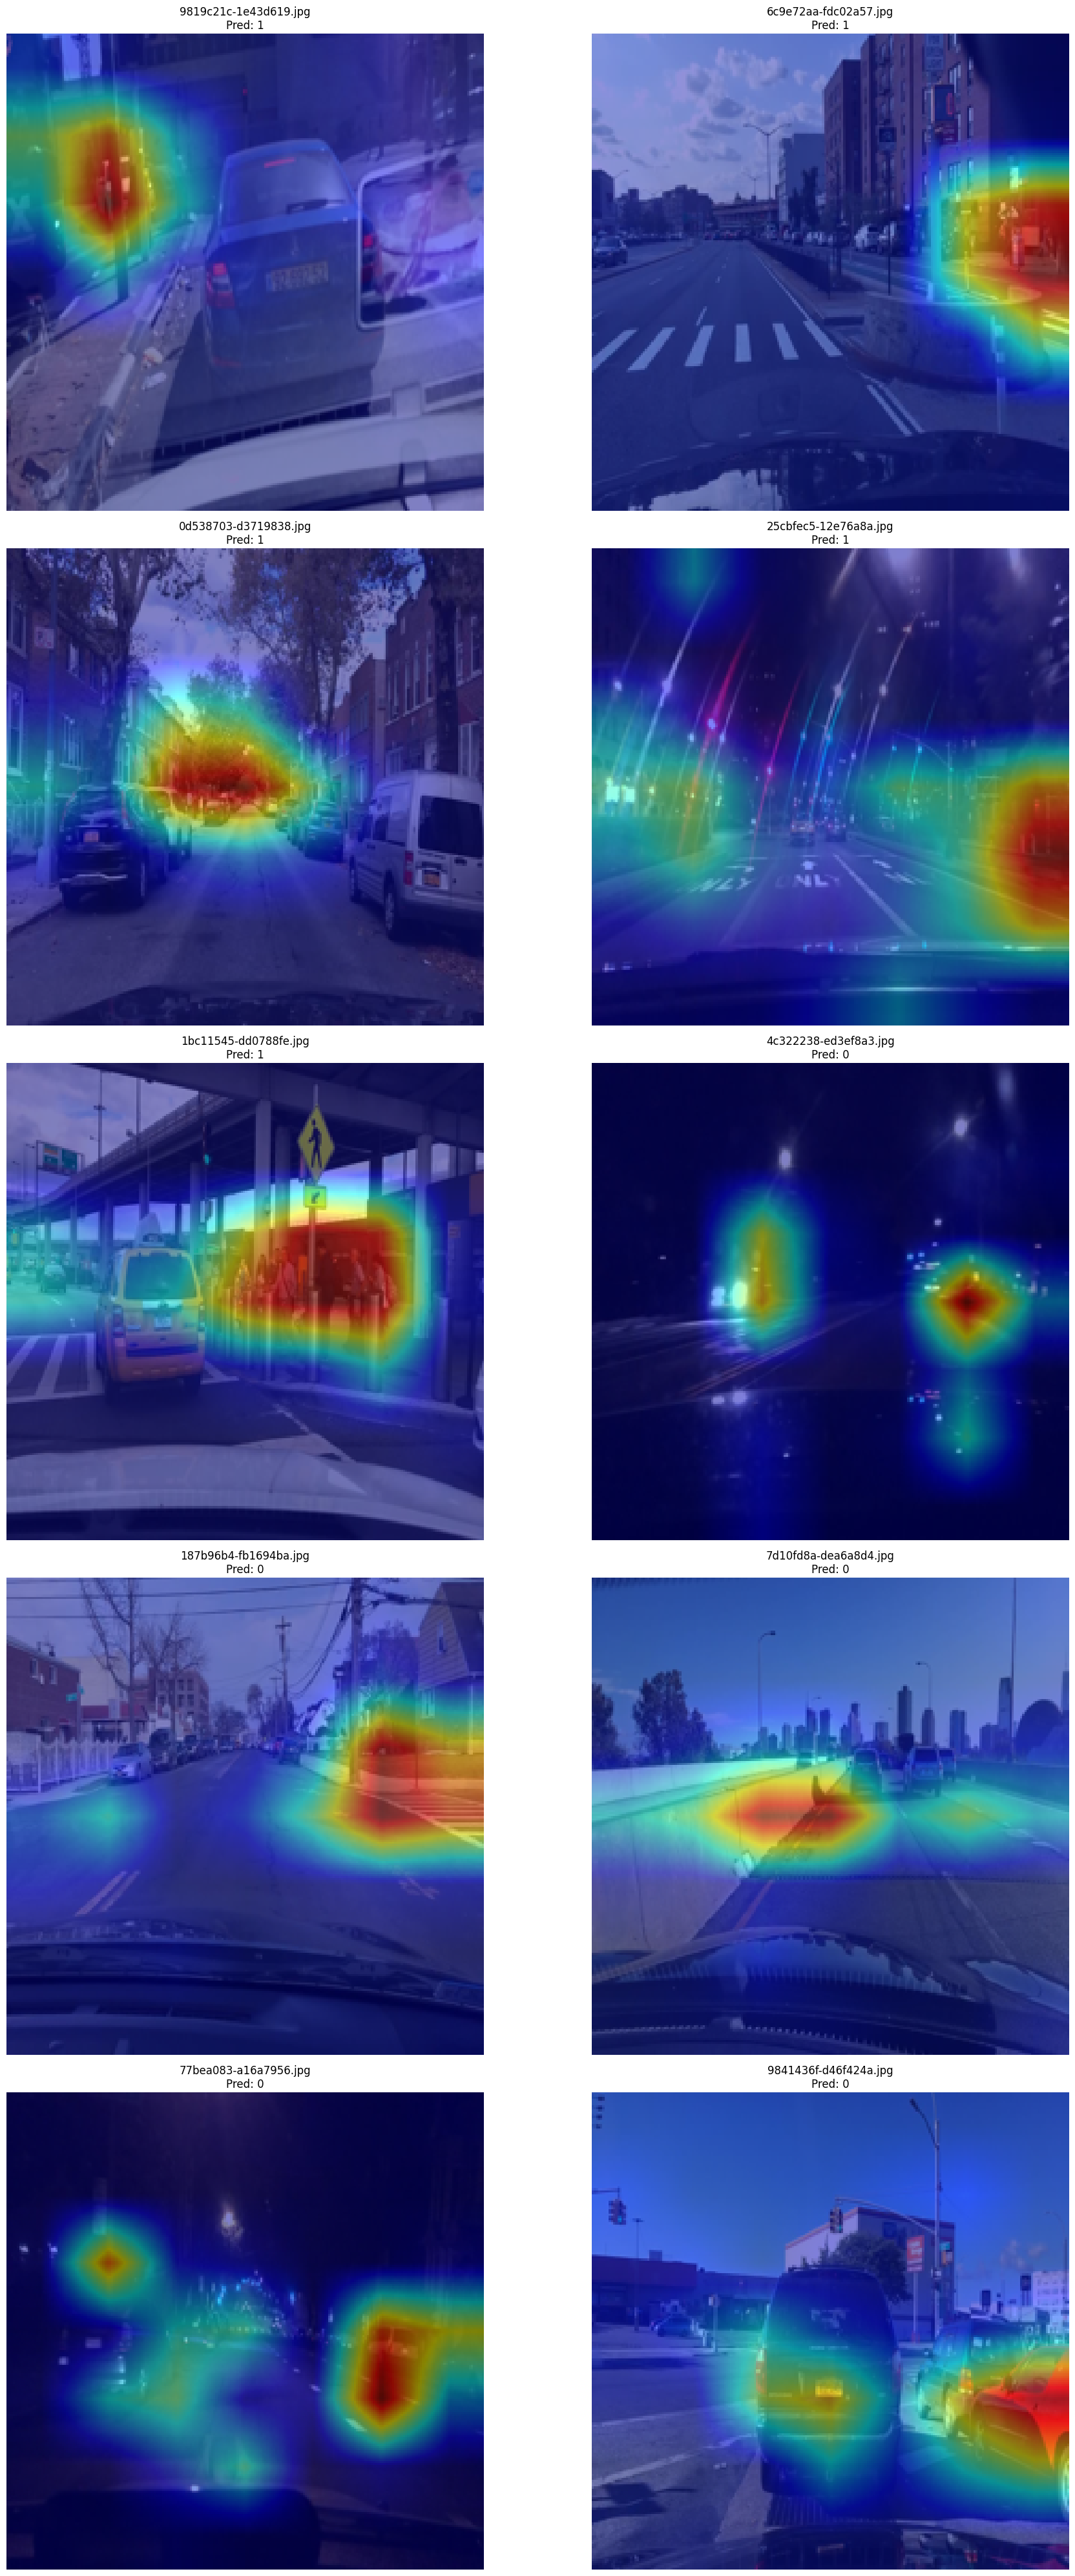

In [17]:
# manual work: debug: remove "use_cuda=True" in ScoreCAM
from pytorch_grad_cam import ScoreCAM
model.eval()
target_layers = [model.layer4[-1]]
cam = ScoreCAM(model=model, target_layers=target_layers)

fig, axes = plt.subplots(5, 2, figsize=(20, 40))
axes = axes.flatten()  # Flatten to 1D array for easy indexing
for idx, img_name in enumerate(selected_imgs):
    img_path = os.path.join(val_img_dir, img_name)
    image = Image.open(img_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).cuda()
    img_np = np.array(image.resize((224, 224))).astype(np.float32) / 255.0
    outputs = model(input_tensor)
    pred_class = outputs.argmax(dim=1).item()
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred_class)])
    grayscale_cam = grayscale_cam[0]
    visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
    axes[idx].imshow(visualization)
    axes[idx].axis('off')
    axes[idx].set_title(f"{img_name}\nPred: {pred_class}")
plt.tight_layout()
plt.show()

## 2.3 Layer-CAM
Layer CAM looks into different layers.  
Genereated using Perplexity 17:00 10/1/2025

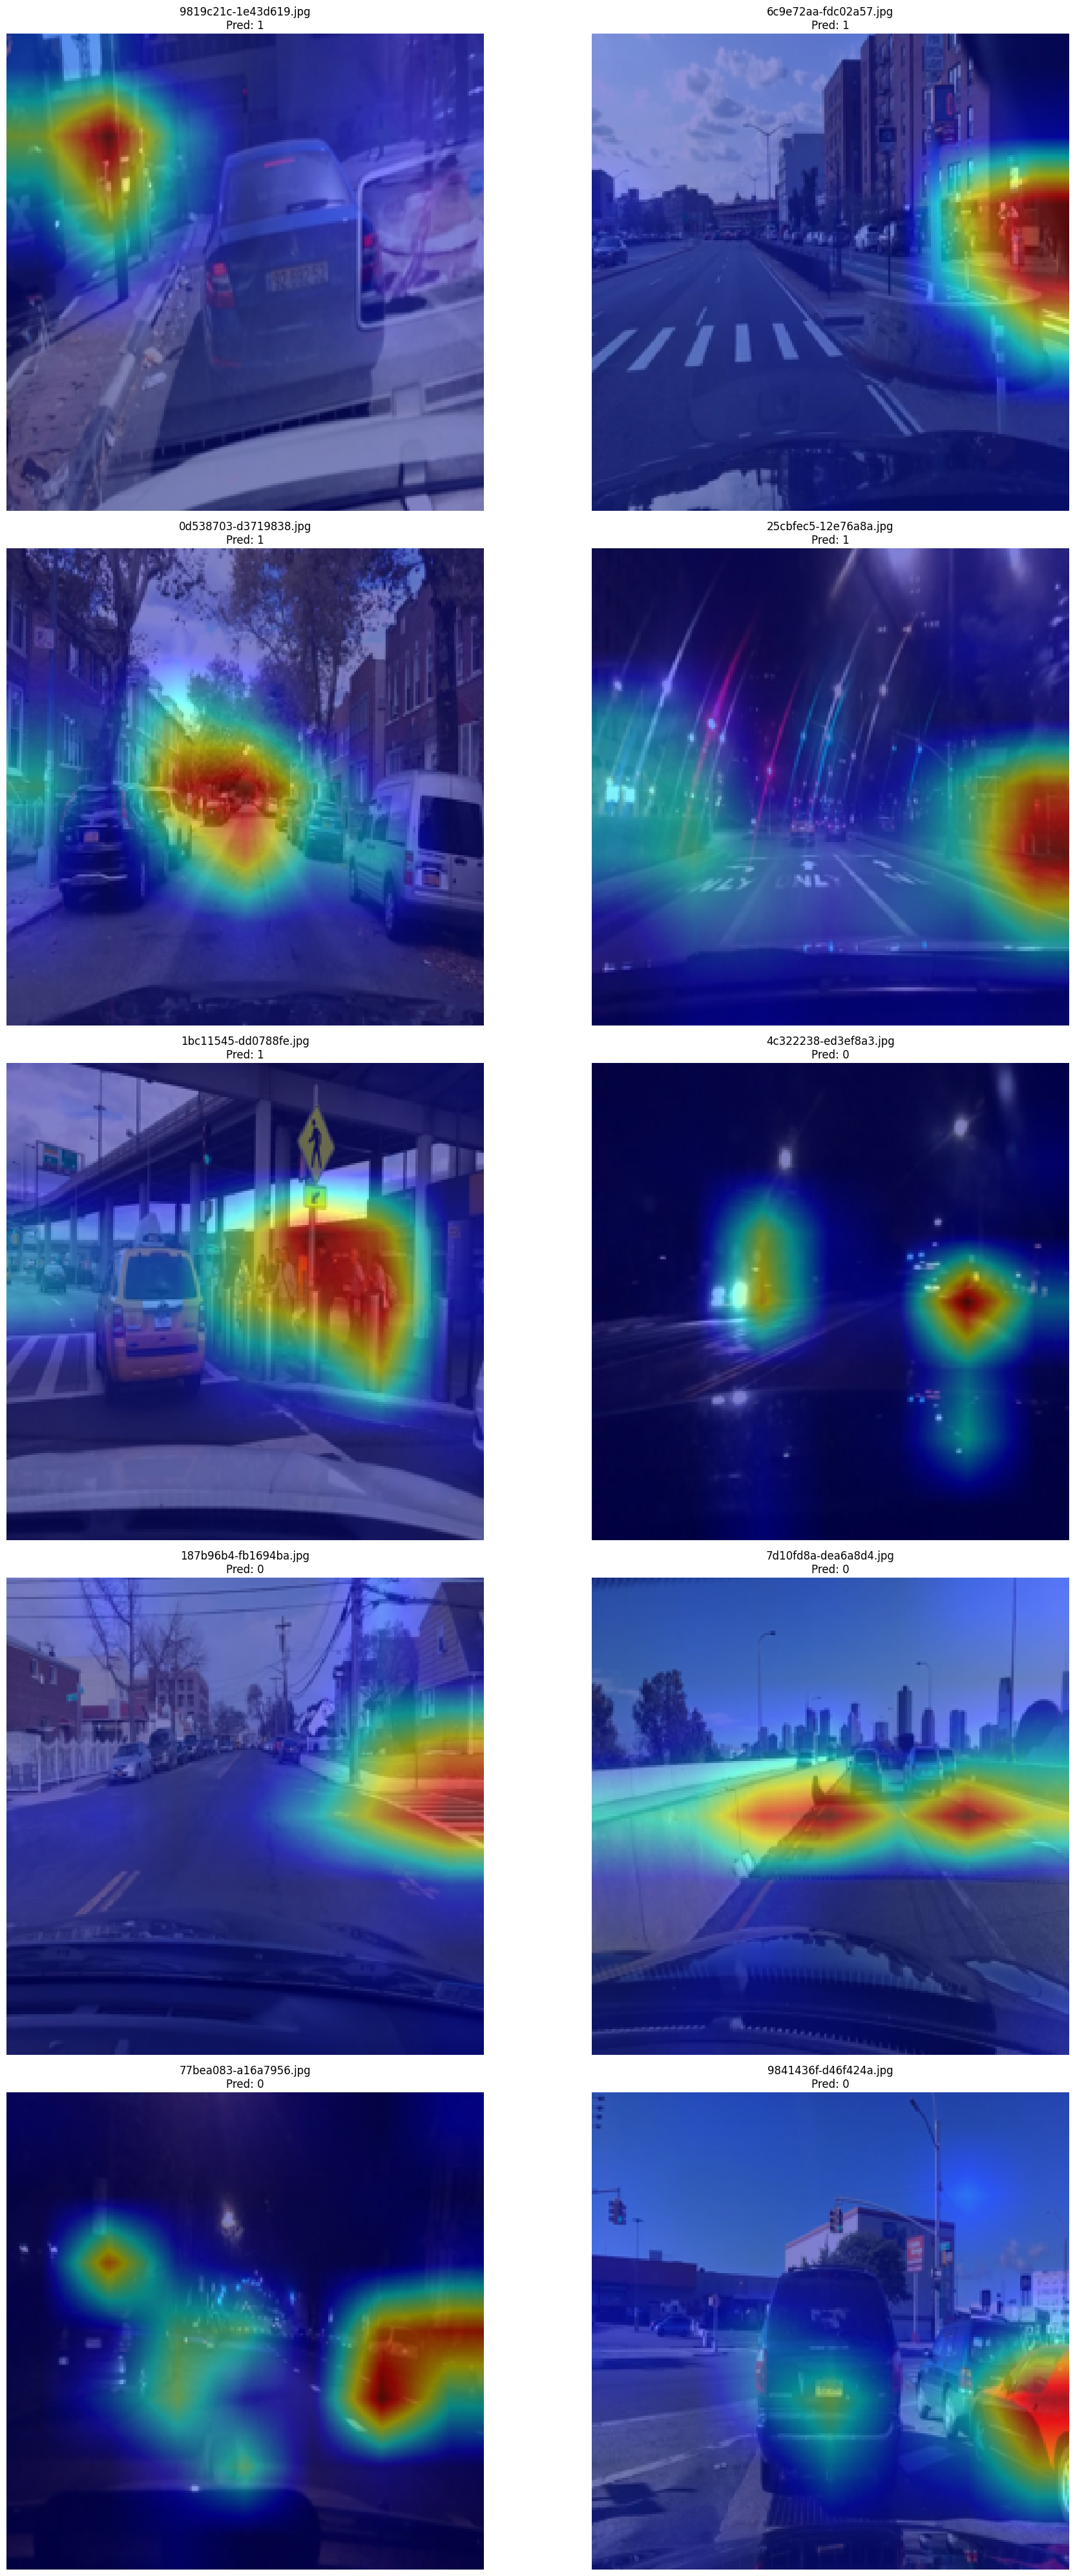

In [18]:
from pytorch_grad_cam import LayerCAM

model.eval()
target_layers = [model.layer4[-1]]
cam = LayerCAM(model=model, target_layers=target_layers)

fig, axes = plt.subplots(5, 2, figsize=(20, 40))
axes = axes.flatten()  # Flatten to 1D array for easy indexing
for idx, img_name in enumerate(selected_imgs):
    img_path = os.path.join(val_img_dir, img_name)
    image = Image.open(img_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).cuda()
    img_np = np.array(image.resize((224, 224))).astype(np.float32) / 255.0
    outputs = model(input_tensor)
    pred_class = outputs.argmax(dim=1).item()
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred_class)])
    grayscale_cam = grayscale_cam[0]
    visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
    axes[idx].imshow(visualization)
    axes[idx].axis('off')
    axes[idx].set_title(f"{img_name}\nPred: {pred_class}")
plt.tight_layout()
plt.show()

# 3. Comparative Analysis
Based on the observation from the 10 sample results, including 5 with pedestrians and 5 without, all three models generat similar heatmaps for all the visualized samples.

However, LayerCAM and GradCAM are more closely related, with similar max heat region and similar surroundings patterns.

And for ScoreCAMm, the results seem silightly distorted and shifted from GradCAM. ScoreCAM heatmap color change is also smoother with wider transition boundaries. And for the case with a group of people, it covers more people than other two models.  

# 4. Reflection
1. Whether the model focused on appropriate cues:  
For postitive cases (with pedestrian), all three models could mark out the pedestrian on the curb. And for negative cases (without pedestrian), the models were focused on other sidewalks, cars, other traffic lanes and pedestrian crossing, which are reasonable focus to determine the existence of pedestrian.  
However, for a picture with both pedestrian and traffic light rod, the CAM result marked traffic light rod as the main focus instead of pedestrian.

2. Any surprising or misleading results:  
Surprising: same as above, for a picture with both pedestrian and traffic light rod, the CAM result marked traffic light rod as the main focus instead of pedestrian. This could mean that the model still have different understanding of "pedestrian" compared to human interpretation.

3. The significance of explainability in chosen domain:  
The safety of pedestrain is important since pedestrains are least protected on street. Thus extra attention should be given when they present. The explainablility of detecting pedestrian provides insight of why the model decide there are pedestrians in view. It gives people an option to verify the rationale behind the scenario classification result and make the decision making more transparent. It is also a good basis for model improvement to handle the control more carefully when pedestrian is detected.  
